In [137]:
action_types = ['default', 'grenade', 'shield', 'reload', 'punch', 'spear', 'hammer', 'portal', 'spider', 'logout']

In [138]:
import tensorflow as tf
import platform

print(f'Python Platform: {platform.platform()}')
print(f'Tensorflow Version: {tf.__version__}')
gpu = len(tf.config.list_physical_devices('GPU'))>0
print('GPU is', 'available' if gpu else 'NOT AVAILABLE')

Python Platform: Linux-5.15.90.1-microsoft-standard-WSL2-x86_64-with-glibc2.35
Tensorflow Version: 2.13.0
GPU is NOT AVAILABLE


In [139]:
# Read CSV

import sys
import os
import csv
import numpy as np

home_path = sys.path[0]
rel_path = 'trim_util/trimmed_csv'
total_path = os.path.join(home_path, rel_path)

X = []
y = []

for file in os.listdir(total_path):
    if file.endswith(".csv"):
        p = os.path.join(total_path, file)
        f = open(p, 'r')
        r = csv.reader(f, delimiter=',')
        next(r)
        X.append(list(r))
        y.append(file.split('_')[0])

X = np.array(X)
X = X.astype(float)
y = np.array([action_types.index(s) for s in y])
print(np.info(X))
print(y[0])

class:  ndarray
shape:  (40, 40, 3)
strides:  (960, 24, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x55e92294a6b0
byteorder:  little
byteswap:  False
type: float64
None
2


In [140]:
# Normalize each sample for training

from scipy.stats import zscore
from scipy import signal

noscale_X = X.copy()

# Extract label

for sample in X:
    signal.detrend(sample, axis=0)
    zscore(sample, axis=0)

In [141]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

X_train.shape, X_test.shape

((32, 40, 3), (8, 40, 3))

In [142]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPool2D, Input
from tensorflow.keras.optimizers import Adam

num_classes = len(action_types)

model = Sequential()
model.add(Input(shape=(40, 3))) # actually should be (40, 12)
model.add(Conv1D(32, 5, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 36, 32)            512       
                                                                 
 flatten_8 (Flatten)         (None, 1152)              0         
                                                                 
 dense_16 (Dense)            (None, 64)                73792     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 10)                650       
                                                                 
Total params: 74954 (292.79 KB)
Trainable params: 74954 (292.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [143]:
num_epochs = 20
history = model.fit(X_train, y_train, epochs = num_epochs, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20


1/1 [==============================] - 0s 438ms/step - loss: 1.7687 - accuracy: 0.5625 - val_loss: 4.6725e-04 - val_accuracy: 1.0000
Epoch 2/20
1/1 [==============================] - 0s 23ms/step - loss: 0.1465 - accuracy: 0.9375 - val_loss: 2.5183e-06 - val_accuracy: 1.0000
Epoch 3/20
1/1 [==============================] - 0s 23ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 1.4901e-08 - val_accuracy: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 21ms/step - loss: 0.0147 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 21ms/step - loss: 2.8908e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 22ms/step - loss: 3.4710e-04 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 22ms/step - loss: 3.6629e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.00

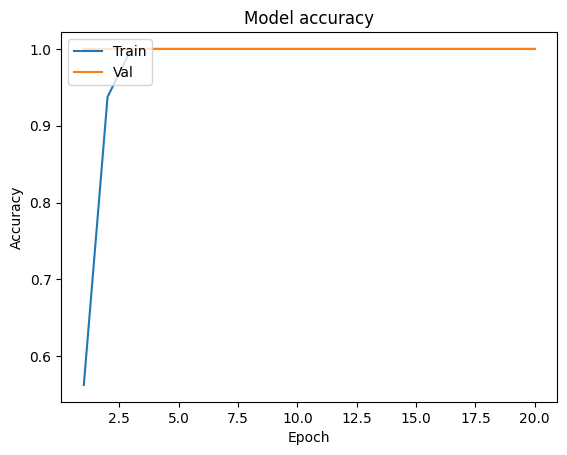

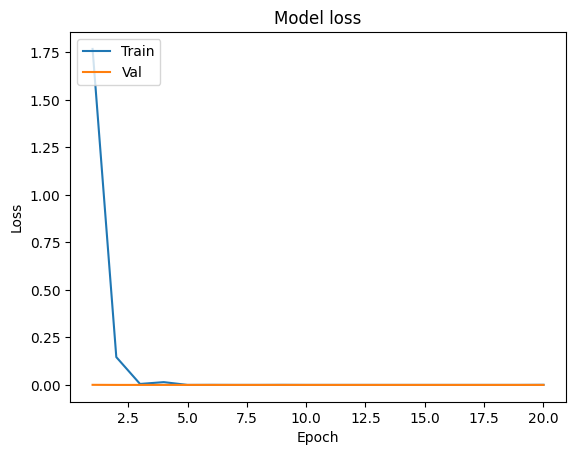

In [144]:
import matplotlib.pyplot as plt

def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

plot_learningCurve(history, num_epochs)

In [151]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# predict_classes generates class predictions for the input samples.

y_pred = model.predict(X_test)
y_classes = np.argmax(y_pred,axis=1)

print(y_test)

mat = confusion_matrix(y_test, y_classes)
plot_confusion_matrix(conf_mat=mat, class_names=action_types, show_normed=True, figsize=(8,8))

1/1 [==============================] - 0s 14ms/step
[2 2 2 2 2 2 2 2]


AssertionError: len(class_names) should be equal to number ofclasses in the dataset